# Conten Based filtering using audio features, album_uri and artist_uri

This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.

In [1]:
import import_ipynb

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import scipy.sparse as sps

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from category_encoders import TargetEncoder
from time import time
import operator

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#own functions
from evaluation import DCG
from evaluation import nDCG
from evaluation import R_Precision
from itertools import islice

%matplotlib inline

importing Jupyter notebook from evaluation.ipynb
DCG = 0.5
IDCG = 1.0
nDCG = 0.5


# Define function to look up similar items 

In [3]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------

def similar_items(track_uri, top_n, similarity_matrix):
    """
    input: 
        track_uri
        top_n - top_n similar tracks to find
        similarity_matrix - similarity matrix between tracks
    output: 
        top_n recommended track_uris
    """
    D_rec={}
    idx = D_track_uri_to_id[track_uri]
    similarity_array = cosine_similarity(similarity_matrix[idx:idx+1,:], similarity_matrix)
    recc_tracks = np.fliplr(similarity_array.argsort())
    for el in recc_tracks[0][1:top_n+1]:
        D_rec[D_track_id_to_uri[el]]=similarity_array[0][el]
    return D_rec

In [4]:
#-------------------------------------
# FIND SIMILAR ITEMS WITH DESCRIPTION
#-------------------------------------

def similar_items_with_description(track_uri, top_n, similarity_matrix):
    """
    input: 
        track_uri
        top_n - top_n similar tracks to find
        similarity_matrix - similarity matrix between tracks
    output: 
        top_n recommended track_uris
    """
    print('CB audio features - first tracks returned is the seed track')
    D_rec={}
    time0 = time()
    idx = D_track_uri_to_id[track_uri]
    similarity_array = cosine_similarity(similarity_matrix[idx:idx+1,:], similarity_matrix)
    recc_tracks = np.fliplr(similarity_array.argsort())
    for el in recc_tracks[0][0:top_n+1]:
        D_rec[D_track_id_to_uri[el]]=D_desc[D_track_id_to_uri[el]]
    print(f'{time()-time0:0.2f}sec')
    return list(D_rec.values())

In [5]:
def similar_items_with_description_external(track_uri, top_n):
    print('CB audio features - first tracks returned is the seed track')
    D_rec={}
    time0 = time()
    idx = D_track_uri_to_id[track_uri]
    similarity_array = cosine_similarity(X_transformed[idx:idx+1,:], X_transformed)
    recc_tracks = np.fliplr(similarity_array.argsort())
    for el in recc_tracks[0][0:top_n+1]:
        D_rec[D_track_id_to_uri[el]]=D_desc[D_track_id_to_uri[el]]
    print(f'{time()-time0:0.2f}sec')
    return list(D_rec.values())

In [6]:
#----------------------------------------------------------------------
# PREDICT TOP_N TRACKS FOR A PID AND EVALUATE AGAINST THE GROUND TRUTH
#----------------------------------------------------------------------

def predict_and_evaluate_top_n(pid,top_n):
    """
    input: 
        pid
        top_n - top_n similar tracks to find
    return
        top_n predicted track_ids
        ground_truth : track_ids in the hold_out
        R_Prec
    """
    train_array_track_ids = track_id_array[M[pid].toarray()[0].astype(bool)]
    
    D_pred={}
    
    topn_n_by_track = (int(top_n/len(train_array_track_ids))+1)*2
    
    for el in train_array_track_ids:
        D_pred.update(similar_items(D_track_id_to_uri[el],topn_n_by_track,X_transformed))
    
    D_pred = dict(sorted(D_pred.items(), key=operator.itemgetter(1),reverse=True))
    ground_truth = ev_set_arr[ev_set_arr[:,0]==pid][:,2]
    L_pred = list(D_pred.keys())[:top_n]
    R_Prec = R_Precision(L_pred[:len(ground_truth)],ground_truth)
    res = [int(el in list(ground_truth)) for el in L_pred]
    NDCG = nDCG(res)[1]
    return L_pred, ground_truth, R_Prec, NDCG, res

In [7]:
#----------------------------------------------------------------------
# PREDICT TOP_N TRACKS WITH DESCRIPTION FOR A PID
#----------------------------------------------------------------------

def create_pid_recs_with_description(pid,top_n):
    """
    return
        top_n predicted track_ids with description
    """
    print(f'Recommendations for {pid}')
    train_array_track_ids = track_id_array[M[pid].toarray()[0].astype(bool)]
    
    D_pred = {}
    L_pred = []
    topn_n_by_track = (int(top_n/len(train_array_track_ids))+1)*2
    for el in train_array_track_ids:
        D_pred.update(similar_items(D_track_id_to_uri[el],topn_n_by_track,X_transformed))
    
    D_pred = dict(sorted(D_pred.items(), key=operator.itemgetter(1),reverse=True))
    
    L_pred_k = list(D_pred.keys())[0:top_n]
    
    
    for k in L_pred_k:
         L_pred.append(D_desc[k])

    return L_pred

In [8]:
#------------------------------------------------------------------------
# SEARCH FOR AN ARTIST OR TRACK BASED ON THE NAME OF AN ARTIST OR TRACKS
#------------------------------------------------------------------------

def search_track_artist(name, entity):
    """
    input:
        name of an artist or track
        entity - 'track' or 'artist'
    return:
        track_uri for a given artist name or a track name
    """
    
    S = []
    if entity == 'track':
        for k, v in D_desc.items():
            if v[0].lower().find(name.lower()) !=-1:
                S.append([k, v])
    if entity == 'artist':
        for k, v in D_desc.items():
            if v[1].lower().find(name.lower()) !=-1:
                S.append([k, v])     
    return S

# Load data

In [9]:
with open('../data-processed/full-data/track_descriptions.json') as json_file:
    D_desc = json.load(json_file)
    
D_desc['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI']

['Lose Control (feat. Ciara & Fat Man Scoop)', 'Missy Elliott', 'The Cookbook']

In [10]:
with open('../data-processed/full-data/track_artist_album.json') as json_file:
    D_album_artist = json.load(json_file)
    
D_album_artist['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI']

['spotify:artist:2wIVse2owClT7go1WT98tk',
 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K']

In [11]:
path = '../data-processed/full-data/audio-features-combined.csv'
data = pd.read_csv(path)

In [12]:
data = data.reset_index()
data = data.rename(columns = {'index':'track_id'})
data['artist_uri'] = data.apply(lambda x:D_album_artist[x.uri][0], axis = 1)
data['album_uri'] = data.apply(lambda x:D_album_artist[x.uri][1], axis = 1)

In [13]:
# data.head()

In [14]:
D_track_uri_to_id = data.groupby('uri')['track_id'].min().to_dict()
D_track_id_to_uri = data.groupby('track_id')['uri'].min().to_dict()

In [15]:
len(D_track_uri_to_id), len(D_track_id_to_uri)

(2262190, 2262190)

In [16]:
data.head()

,track_id,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_uri,album_uri
0,0,spotify:track:5OSaZxhNj307YpTh7Qp8Xy,0.716,0.421,7,-11.560,0,0.0275,0.649000,0.002070,0.0936,0.2070,99.078,378440,4,spotify:artist:1vSHzGHsVOCrgPSCmKNimP,spotify:album:0oA1WetYmmrxkyjxz92yJg
1,1,spotify:track:4zytmsfZ7HtdXj3VLECcu2,0.141,0.441,5,-12.893,1,0.0892,0.700000,0.687000,0.1280,0.0725,76.044,331000,4,spotify:artist:6gHYtzSvIIWvoUY2q2V3Rj,spotify:album:3c1gpGKfahKOFXtM7eIcFO
2,2,spotify:track:6lOWUS7iBVEw6ieJqxH17B,0.799,0.893,8,-5.496,1,0.0635,0.000018,0.914000,0.3620,0.5290,128.009,469397,4,spotify:artist:7kxOVclB0zQamtBR0syCrg,spotify:album:0mX83KZvGWqBOvI4nIZ23H
3,3,spotify:track:3OSL6hJ9DoRGwr9OSEVrRS,0.789,0.548,4,-7.167,1,0.0418,0.707000,0.000934,0.0616,0.5930,117.713,153893,4,spotify:artist:2sxmKe3CUrWnx7eoXMhOlW,spotify:album:4hXCM8vqLJnlFcuHoH3zVP
4,4,spotify:track:6x0bgGOKckFsesVf7yPWJq,0.728,0.670,3,-7.912,0,0.1020,0.157000,0.000797,0.1080,0.0647,119.963,196000,4,spotify:artist:6PyeXqjH8OMGnt1IOhWgrQ,spotify:album:1pjNAADvPDurRS42fqxN4k


# Plot data

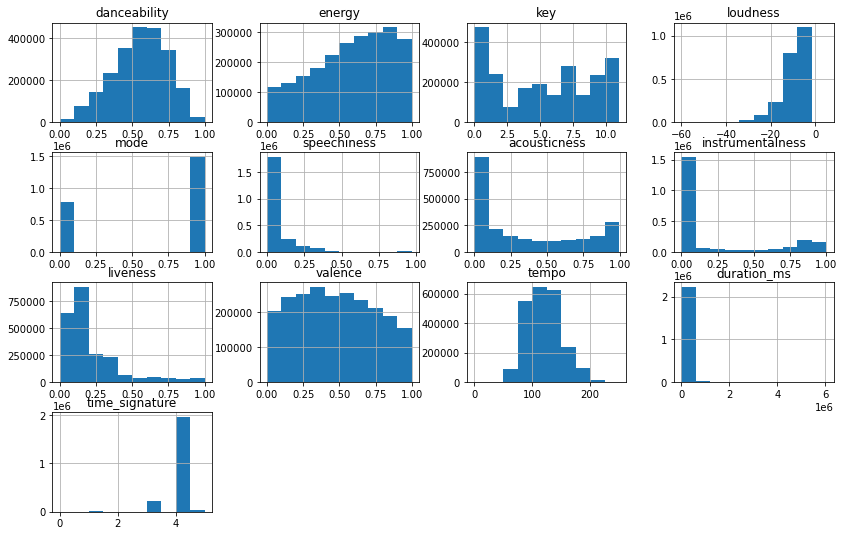

In [17]:
data.iloc[:,1:-1].hist(figsize=(14,9))

plt.show()

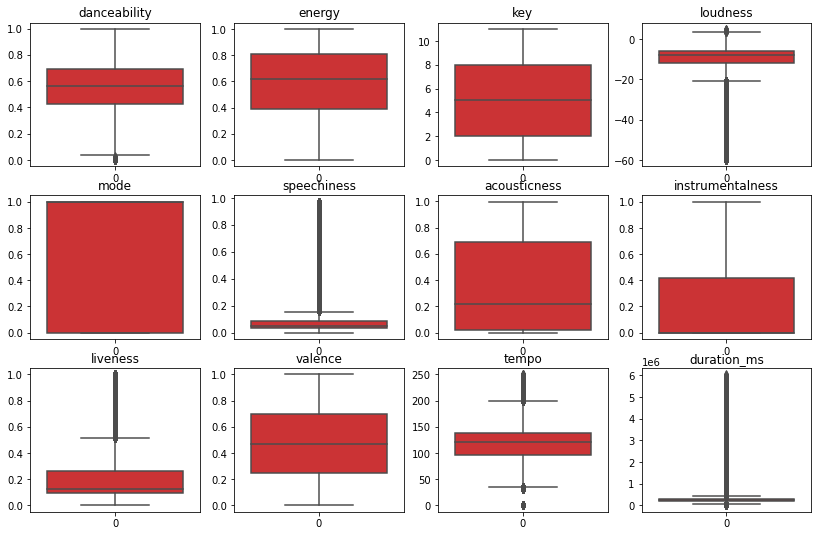

In [18]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(14,9))

column = data.columns[2:14]

for i in range(3):
    for j in range(4):
        sns.boxplot(data=data[column[i*4+j]], palette="Set1", ax=ax[i,j]).set_title(column[i*4+j])

# Standardize data 

In [19]:
X = data.iloc[:,2:13]

data.iloc[:,2:13].columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [20]:
scaler = StandardScaler()
transformer = scaler.fit(X)
X_transformed = transformer.transform(X)

In [21]:
# uncomment
# pd.DataFrame(X_transformed).hist(figsize=(14,9))
# plt.show()

# Target encode album_uri and artist_uri

In [22]:
X_transformed.shape

df_X_transformed = pd.DataFrame(X_transformed, columns=data.iloc[:,2:13].columns)
# df_X_transformed.head()

df_X_transformed.shape

(2262190, 11)

In [23]:
df_X_transformed.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

# Encode album_uri

In [24]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

df_X_transformed['album_uri'] = data.album_uri
X = data['album_uri'].values.reshape(-1,1)

In [25]:
enc = TargetEncoder()
for col in cols:
    y = df_X_transformed[col].values.reshape(-1,1)  
    df_X_transformed[f'album_uri_{col}_enc'] = enc.fit_transform(X, y)

In [26]:
# df_X_transformed.head()

# Encode artist_uri

In [27]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

df_X_transformed['artist_uri'] = data.artist_uri
X = data['artist_uri'].values.reshape(-1,1)

In [28]:
enc = TargetEncoder()
for col in cols:
    y = df_X_transformed[col].values.reshape(-1,1) 
    df_X_transformed[f'artist_uri_{col}_enc'] = enc.fit_transform(X, y)

In [29]:
# df_X_transformed.head()

In [30]:
X_transformed = df_X_transformed.drop(columns=['artist_uri','album_uri']).to_numpy()

# Perform PCA - recommendations can be done using dimensionality reduction on using all features by passing  X_transformed or X_transformed_pca

In [31]:
X_transformed.shape

pca = PCA(n_components='mle')
pca = pca.fit(X_transformed)

In [32]:
# print(pca.explained_variance_ratio_)

In [33]:
X_transformed_pca = pca.transform(X_transformed)

> Let us run PCA with 15 factors

In [34]:
pca = PCA(n_components=15)
pca = pca.fit(X_transformed)
print(pca.explained_variance_ratio_)

print(f'Explained variance = {np.sum(pca.explained_variance_ratio_):0.2f}')

[0.31535805 0.11036058 0.09556642 0.0776244  0.056072   0.05212492
 0.04761578 0.04211778 0.02992701 0.02492938 0.02194851 0.01280628
 0.01257943 0.01206745 0.01069731]
Explained variance = 0.92


In [35]:
X_transformed_pca = pca.transform(X_transformed)

# Load evaluation set

In [36]:
file_path = '../data-processed/full-data/pid-track-pos-rating-train-data.csv'
data2 = pd.read_csv(file_path)

In [37]:
tracks = list(data2.track_uri.unique())
D_tracks = {}
n=0
for track in tracks:
    D_tracks[track] = n
    n+=1
    
D_tracks_reverse = {}
n=0
for k,i in D_tracks.items():
    D_tracks_reverse[i] = k
    
data2['track_id'] = data2.track_uri.map(D_tracks)

In [38]:
evaluation_set = pd.read_csv('../data-processed/full-data/evaluation-pids-ground-truth.csv')
evaluation_set['track_id'] = evaluation_set['track_uri'].map(D_tracks)
ev_set = evaluation_set[evaluation_set['hold_out'] == 1][['pid','track_id','track_uri','hold_out']]
ev_set = ev_set[ev_set.track_id.isnull()==False]
evaluation_pids = list(ev_set.pid.unique())
ev_set.track_id = ev_set.track_id.astype(int)
ev_set_arr = ev_set.to_numpy()

In [39]:
M = sps.csr_matrix((data2.pos_rating, (data2.pid, data2.track_id)))
track_id_array = np.arange(M.shape[1])

# `~~~~~~~~~~~~~~~~~~~~~~~~~~~ DEMO TIME~~~~~~~~~~~~~~~~~~~~~~~~~~~`

<img src="tenor.gif">

# Search for tracks or artists

In [40]:
track_or_artist = 'spice girls'
entity = 'artist'
results_to_print = 5
search_track_artist(track_or_artist, entity)[0:results_to_print]

[['spotify:track:1Je1IMUlBXcx1Fz0WE7oPT',
  ['Wannabe - Radio Edit', 'Spice Girls', 'Spice']],
 ['spotify:track:1yTQ39my3MoNROlFw3RDNy',
  ["Say You'll Be There - Single Mix", 'Spice Girls', 'Spice']],
 ['spotify:track:1RQnYh2xw2BPpnzQFbO5r5',
  ['Too Much', 'Spice Girls', 'Spiceworld']],
 ['spotify:track:5qGwqO0lkbBXw4xNfzT7SF',
  ['Spice Up Your Life', 'Spice Girls', 'Spiceworld']],
 ['spotify:track:3FteycP8CaXS1MhjcXekVT',
  ['Stop', 'Spice Girls', 'Spiceworld']]]

# Find similar tracks

In [41]:
similar_items_with_description('spotify:track:4QlzkaRHtU8gAdwqjWmO8n',10,X_transformed)

CB audio features - first tracks returned is the seed track
5.49sec


[["Friday I'm In Love", 'The Cure', 'Wish'],
 ['Sleeping Beast', 'Skinny Puppy', 'Remission'],
 ['Cut', 'The Cure', 'Wish'],
 ['Celebrate Youth', 'Rick Springfield', 'Tao'],
 ['Bad Boys Running Wild', 'Scorpions', 'Love At First Sting'],
 ['Without The Night', 'Winger', 'Winger'],
 ['Weird At My School', 'Pixies', 'Monkey Gone To Heaven'],
 ['Pride', 'Buckcherry', 'Confessions'],
 ['Cafe', 'Malo', 'MALO Rocks the Rockies'],
 ['Lines And Lines', 'The Spinanes', 'Strand'],
 ['What Does It Matter', 'Molly Hatchet', 'No Guts...No Glory']]

# Create a playlist continuation

In [42]:
inp = 676551
create_pid_recs_with_description(inp, 20)

Recommendations for 676551


[['La Rasquina', 'Aniceto Molina', '20 Cumbias De Reventon'],
 ['Hot Blooded - Live At The Bang Your Head Festival, Balingen, Germany/2006',
  'Foreigner',
  "Alive & Rockin'"],
 ['Feels Like the First Time - Live', 'Foreigner', 'The Best of 4 and More'],
 ['Faith', 'Raffa Fl', 'Revolution'],
 ['D-Boy Rap', 'Grim G', 'Find a Way Out'],
 ["Voodoo Of The Sheep - Barem's Amado Voodoo Remix",
  'Jay Tripwire',
  'Akbal Music Remixed, Vol. 2'],
 ['Forrest Gump Suite on Piano', 'Dagmar Krug', 'Forrest Gump Suite on Piano'],
 ['Truth Pt. 1', 'Diabolic', 'Foul Play Mixtape'],
 ['Up - solo piano theme',
  'Mark Northam',
  'Up - Theme from the Disney/Pixar Motion Picture by Michael Giacchino'],
 ['Seems Like Most Everything Used To Be Something Else',
  'The Six Parts Seven',
  'Things Shaped In Passing'],
 ['Falling In and Out Of Love - Original',
  "King Cole's Swingsters",
  "King Cole's Swingsters Selected Favorites, Vol. 1"],
 ['Where Are The Timpani Heartbeats?',
  'The Six Parts Seven',


# Save evaluation results - needs to be uncommented

In [43]:
# n=1
# time0=time()
# epid = random.sample(evaluation_pids,n)
# evaluation_result = {}
# for i,pid in enumerate(epid):
#     evaluation = predict_and_evaluate_top_n(pid,500)
#     evaluation_result[pid] = [evaluation[2],evaluation[3]]
#     if i%10==1:
#         print(time() - time0)
# df = pd.DataFrame(evaluation_result).transpose().reset_index()
# df.columns=['pid','R-Precision','nDCG']
# df['rating'] = 'na'
# model = f'CB_audio_features'
# df['model'] = model
# df.to_csv(f'../evaluation/{model}_{n}.csv', index = None)

# print(time() - time0)

# df.describe()